In [ ]:
#|hide
#|default_exp experiments.graph_volume_normalization
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

# Utility functions for literate programming
def get_var_name(instance):
    return [name for name, obj in globals().items() if obj is instance][0]

%load_ext autoreload
%autoreload 2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# 2c5 Graph Volume Normalization
> Resilience to sampling/density by normalizing the laziness by the volume.

## Preamble
Unsigned diffusion laziness conflates the speed and spread of diffusion, but this involves two interrelated phenomena:
1. Volume expansion, which happens faster in spaces of negative curvature.
2. *Laziness*, which is related to volume expansion, but also involves more interconnectivity between points. 

Can we separate speed from spread by normalizing the laziness by the number of points diffused to? On the sphere, the same *area* should have lazier diffusions than on the saddle.

I’m unsure if the laziness phenomenon is strong enough by itself. Normalizing by e.g. the number of points with diffusion higher than $\epsilon$ might just destroy the effect.
- But there could be ways of intensifying it. Perhaps taking circular subsets of the data and repeatedly diffusing just within that confined space?
- The ‘volume curves’ could also be matched between datasets

## Research Question

In this notebook, we investigate enhancing the sampling resilience of diffusion curvature by normalizing by the graph volume, as a proxy for density. The experiment first to be done is this:

> Does the diffusion laziness, normalized by a proxy of graph volume (e.g counting the number of points), still reveal curvature?

This will be tested on the `SadSpheres` dataset at various dimensions, and with various normalization schemes. Perhaps dividing, perhaps directly comparing curvature curves, perhaps some yet to be discovered means.

## Hypothesis

> When normalized by graph volume, the curvature curves of positive and negative datasets will reveal robust differences. The *laziness* of diffusion, in short, can be separated from how quickly it spreads.

## Result Summary


# Machinery

We need to implement two main chunks.

1. A computation of graph volume, accomplished by summing up the number of points at in which each row of $P^t$ exceeds an epsilon threshold. We'll do this with a fastai style mixin that calls `unsigned_curvature`, extracts the `Pt` variable, and does its will.
2. A means of normalizing the unsigned curvature (laziness) by the resulting volume. The simplest is division, but I want to try several out. To do so, we'll define a series of normalization functions that take a,b and return some ratio of them. We also want direct access to the graph volumes and unsigned curvatures, so each normalization function will itself be a patch.

In [ ]:
#|export
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from fastcore.all import *
from diffusion_curvature.core import *

@patch 
def graph_volumes(self:DiffusionCurvature, epsilon_threshold = 1e-5):
    """
    returns the graph volumes across all idxs. Presumes that Pt is precomputed.
    """
    idxs_above_threshold = (self.Pt > epsilon_threshold).astype(int)
    graph_volumes = jnp.sum(idxs_above_threshold, axis=-1)
    return graph_volumes

@patch
def division_normalized_laziness(self:DiffusionCurvature, G, t, epsilon_threshold, return_all = "norm"):
    laziness = self.unsigned_curvature(G, t)
    volumes = self.graph_volumes(epsilon_threshold = epsilon_threshold)
    norm = laziness / volumes
    if return_all == "all": return norm, laziness, volumes
    elif return_all == "volume": return volumes
    else: return norm

In [ ]:
# import the curvature curves patch
from diffusion_curvature.experiments.curvature_curves import *

# Results

## Dataset Setup

In [ ]:
X_saddle, ks = rejection_sample_from_saddle(2000, intrinsic_dim=2)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_saddle = graph_former(X_saddle)
DC_saddle = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_saddle.fit_transform(G_saddle, dim=2, t=25)

2024-03-28 12:28:10,153:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 12:28:10,764:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
X_sphere, ks_sphere = sphere(2000, d=2)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_sphere = graph_former(X_sphere)
DC_sphere = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former = graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere.fit_transform(G_sphere, dim=2, t=25)

2024-03-28 12:28:11,680:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 12:28:12,280:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
X_plane = plane(2000, dim=2)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_plane = graph_former(X_plane)
DC_plane = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane.fit_transform(G_plane, dim=2, t=25)

2024-03-28 12:28:13,005:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 12:28:13,643:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
X_saddle, ks = rejection_sample_from_saddle(4000, intrinsic_dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_saddle = graph_former(X_saddle)
DC_saddle_dim3 = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_saddle_dim3.fit_transform(G_saddle, dim=2, t=25)

2024-03-28 12:57:23,531:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 12:57:27,340:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
X_sphere, ks_sphere = sphere(4000, d=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_sphere = graph_former(X_sphere)
DC_sphere_dim3 = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former = graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere_dim3.fit_transform(G_sphere, dim=2, t=25)

2024-03-28 12:57:30,799:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 12:57:34,352:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
X_plane = plane(4000, dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_plane = graph_former(X_plane)
DC_plane_dim3 = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane_dim3.fit_transform(G_plane, dim=2, t=25)

2024-03-28 12:57:37,693:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 12:57:41,186:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


## Visualization of 2d Curvature Curves with/without Graph Volume Normalization

This initial sanity-check is promising. The volume normalization successfully separates the saddle, sphere, and plane in 2d, and enhances their separation against unnormalized curvature curves. The caveat: our choice of $\epsilon$ threshold matters enormously. If set too low, the volumes quickly balloon to the number of points in the dataset.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

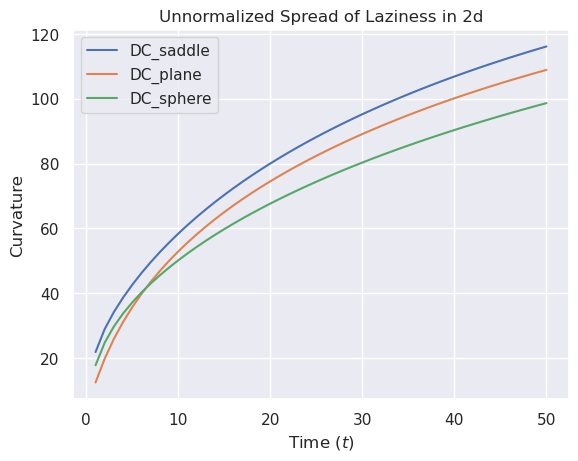

In [ ]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, 
                      num_ts=50, 
                      curvature_fn='unsigned_curvature',
                      title = "Unnormalized Spread of Laziness in 2d")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

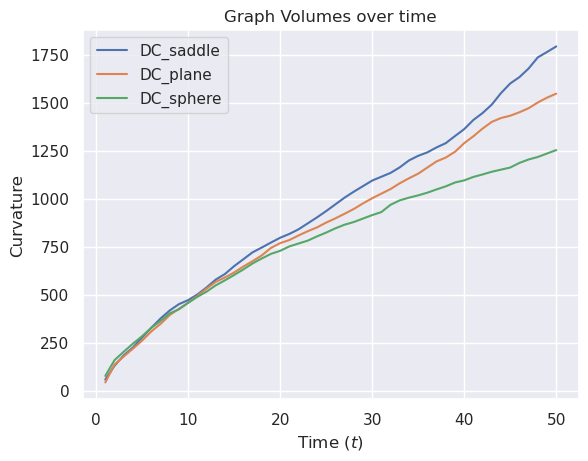

In [ ]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Graph Volumes over time",
                      epsilon_threshold = 1e-4,
                      return_all = "volume"
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

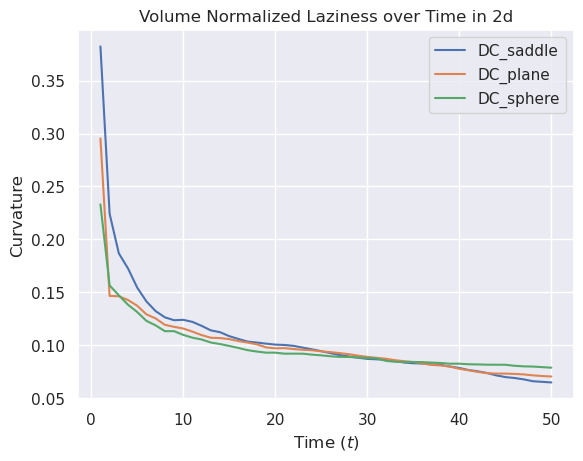

In [ ]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Volume Normalized Laziness over Time in 2d",
                      epsilon_threshold = 1e-4,
                      )

## Visualization of 3d Curvature Curves with/without Graph Volume Normalization

Now here's a harder test: can the normalization distinguish regions which the unaided curvature curves cannot? With 3 manifolds, the curvature curves fail.



In [ ]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='unsigned_curvature',
                      title = "Unnormalized Spread of Laziness in 2d")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

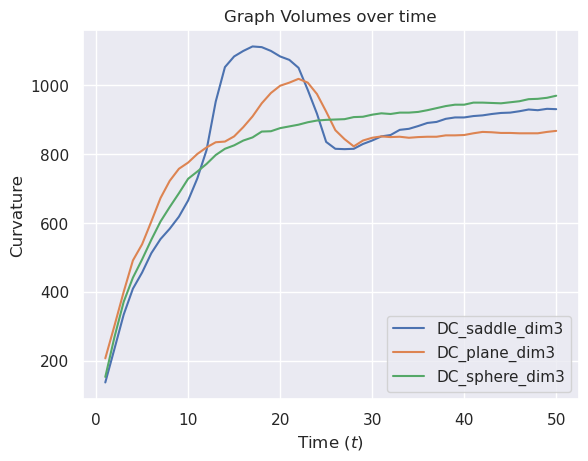

In [ ]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Graph Volumes over time",
                      epsilon_threshold = 1/4000,
                      return_all = "volume"
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

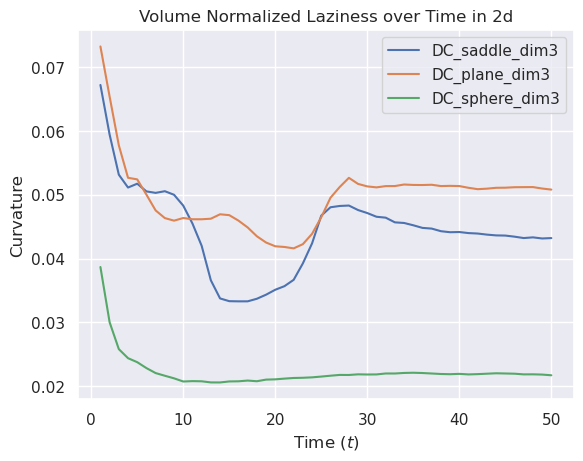

In [ ]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Volume Normalized Laziness over Time in 2d",
                      epsilon_threshold = 1/4000,
                      )

# Conclusion